# github_readme_nlp

In [1]:
# Setup environment
import pandas as pd
from requests import get
from bs4 import BeautifulSoup
import os
import time
import pandas as pd
import numpy as np
import unicodedata
import re
import json
import os
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 10))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import warnings
warnings.filterwarnings('ignore')

import prepare

## Acquire

We acquired all of our READMEs from github.com. We used an API-based script provided by Zach Gulde, but wrote our own methods using the Python requests library to get the list of repositories from which to pull.

Initially, we'd planned to pull the READMEs 100 most-starred repositories of four popular languages on GitHub: Python, JavaScript, PHP, and Shell. These were selected because they appeared to be fairly different from one another, and each was quite popular.

After our first run-through, we noticed some problems with the data. Somehow, we'd gotten some duplicate repositories in there, so we wrote code to ensure only unique repositories would count toward that 100.

We anticipated that we'd likely drop some of these repositories, since some of them appeared to be written in languages other than English, which would not be parsed by our NLP functions. Thus, we wound up grabbing 120 repositories per language, to later be reduced to 100.

## Prepare

Our prepare script takes the original, raw README text and translates it into something more easily understood by NLP algorithms. It also drops READMEs that are incomplete, missing or in a different language. It ultimately produces a dataframe with the original text, cleaned text, stemmed text, lemmatized text and the length in number of characters. If passed the 'model' flag it will also include word count and number of unique words.

We considered a few READMEs with massive word counts and many with very low word counts to be outliers. Those with very low word counts could not be considered for various reasons. Some were in Chinese initially and thus only contained the few anglicized words initially in the README. Others were the wrong README when there were multiple READMEs on a repo page. There were also some that simply said 'removed,' and some that were not READMEs, but symbolic links to the actual README elsewhere in the repository.

In [2]:
df = prepare.prep()

## Prep Summary

- Create data frame with cleaned data and language listed.

In [3]:
lemmas_df = df[['language', 'title', 'lemmatized']]

## Explore & Define Features

### Category Distribution

In [4]:
lemmas_df.dropna(inplace=True)

In [5]:
lemmas_df.shape

(400, 3)

In [6]:
lemmas_df.language.value_counts(normalize = True)

JavaScript    0.25
Python        0.25
PHP           0.25
Shell         0.25
Name: language, dtype: float64

,n,percent
JavaScript,100,0.25
Python,100,0.25
PHP,100,0.25
Shell,100,0.25


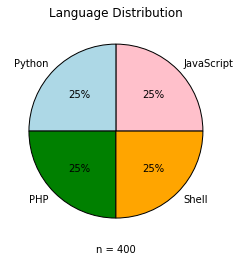

In [7]:
df.language.value_counts().plot.pie(
    colors = ['pink', 'lightblue', 'green', 'orange'], autopct = '%.0f%%')
plt.title("Language Distribution")
plt.ylabel("")
plt.xlabel('n = %d' % df.shape[0])

pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1).set_axis(["n", "percent"], axis = 1, inplace = False)

**Note:** join all Readme and find high count of all words

In [8]:
pd.Series(" ".join(lemmas_df.lemmatized).split()).value_counts().head(10)

react     6312
native    5929
io        3531
img       3496
use       2940
source    2883
href      2724
src       2653
master    2585
svg       2579
dtype: int64

**Note:** words within each language

In [9]:
all_words = ' '.join(lemmas_df.lemmatized).split()

python_words = ' '.join(lemmas_df[lemmas_df.language == 'Python'].lemmatized).split()

javascript_words = ' '.join(lemmas_df[lemmas_df.language == 'JavaScript'].lemmatized).split()

php_words = ' '.join(lemmas_df[lemmas_df.language == 'PHP'].lemmatized).split()

shell_words = ' '.join(lemmas_df[lemmas_df.language == 'Shell'].lemmatized).split()

- Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [10]:
all_freq = pd.Series(all_words).value_counts()

python_words_freq = pd.Series(python_words).value_counts()

javascript_words_freq = pd.Series(javascript_words).value_counts()

php_words_freq = pd.Series(php_words).value_counts()

shell_words_freq = pd.Series(shell_words).value_counts()

### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears. When we move on to computing TF-IDF, this basic definition of Term Frequency applies.

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.

Raw Count: This is simply the count of the number of occurances of each word.
Frequency: The number of times each word appears divided by the total number of words.
Augmented Frequency: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [11]:
raw_count = (
    pd.concat([all_freq, python_words_freq, javascript_words_freq, php_words_freq, shell_words_freq], axis=1, sort=True)
    .rename(columns={0: "All", 1: "Python", 2: "JavaScript", 3: "PHP", 4: "Shell"})
    .fillna(0)
    .apply(lambda col: col.astype(int))
)

In [12]:
raw_count.T

,aa,aaa,aaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaac,aaaaaaaaaai,aaaaaaaad,aaaaaaaaecm,...,zythum,zyusth,zyzsdy,zz,zzan,zzh,zzxadi,zzxcodeformat,zzz,zzzm
All,29,5,2,1,2,1,1,1,1,1,...,1,1,2,6,1,2,2,2,2,2
Python,8,0,0,1,2,1,0,0,0,0,...,0,0,2,0,0,2,0,2,0,2
JavaScript,15,1,0,0,0,0,1,1,1,1,...,1,1,0,4,0,0,0,0,0,0
PHP,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
Shell,0,4,2,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,2,0


**Task** Find record that has &#9

In [13]:
raw_count.sort_values(by="All").tail(10)

,All,Python,JavaScript,PHP,Shell
svg,2579,352,1503,426,298
master,2585,1188,662,341,394
src,2653,327,1835,284,207
href,2724,259,1740,246,479
source,2883,1942,539,103,299
use,2940,772,848,507,813
img,3496,561,2143,402,390
io,3531,846,1880,401,404
native,5929,32,5861,10,26
react,6312,13,6259,35,5


- Most common words overall?
- Most common Python, JavaScript, PHP, Shell words?
- Any words that uniquely Python, JavaScript, PHP, Shell words?

Text(0.5, 1.0, '10 most common words')

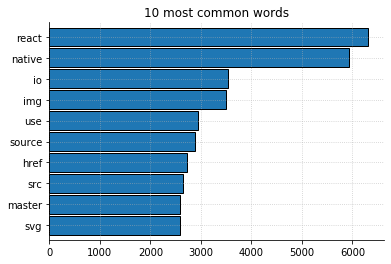

In [14]:
raw_count.sort_values(by='All')['All'].tail(10).plot.barh(width=.9)
plt.title('10 most common words')

Text(0.5, 1.0, '10 most common Python words')

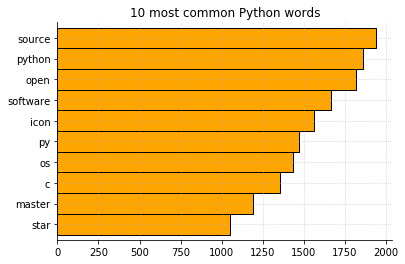

In [15]:
raw_count.sort_values(by='Python').Python.tail(10).plot.barh(width=1, color='Orange')
plt.title('10 most common Python words')

Text(0.5, 1.0, 'What are the most common JavaScript words')

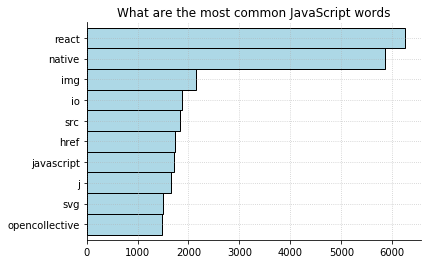

In [16]:
raw_count.sort_values(by='JavaScript').JavaScript.tail(10).plot.barh(width=1, color='lightblue')
plt.title('What are the most common JavaScript words')

Text(0.5, 1.0, 'What are the most common PHP words')

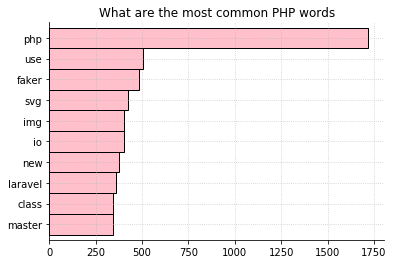

In [17]:
raw_count.sort_values(by='PHP').PHP.tail(10).plot.barh(width=1, color='pink')
plt.title('What are the most common PHP words')

Text(0.5, 1.0, 'What are the most common Shell words')

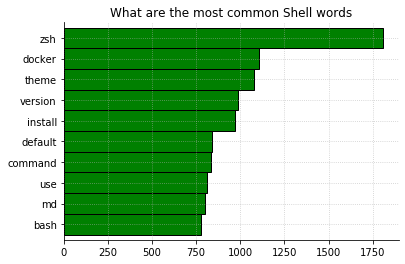

In [18]:
raw_count.sort_values(by='Shell').Shell.tail(10).plot.barh(width=1, color='green')
plt.title('What are the most common Shell words')

In [19]:
raw_count.head()

,All,Python,JavaScript,PHP,Shell
aa,29,8,15,6,0
aaa,5,0,1,0,4
aaaa,2,0,0,0,2
aaaaaaaaaaaa,1,1,0,0,0
aaaaaaaaaaaaaaaaaaaa,2,2,0,0,0


In [20]:
tf_df = raw_count[['All']];
tf_df = tf_df.rename(columns={'All': 'raw_count'})
tf_df = tf_df.assign(frequency = lambda lemmas_df: lemmas_df.raw_count / lemmas_df.raw_count.sum())
tf_df = tf_df.assign(augmented_frequency = lambda lemmas_df: lemmas_df.frequency / lemmas_df.frequency.max())
tf_df.frequency.max()

tf_df.sample()


,raw_count,frequency,augmented_frequency
etag,6,0.000009,0.000951


### Ngrams

- Bigrams and visualizations of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Bigrams for All Words')

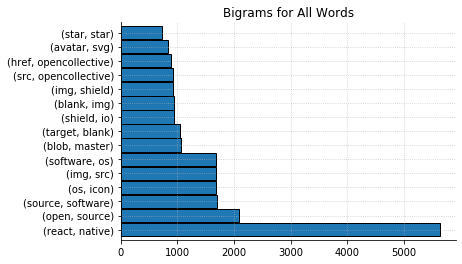

In [21]:
pd.Series(nltk.bigrams(all_words)).value_counts().head(15).plot.barh(width=.95).set_title('Bigrams for All Words')

Text(0.5, 1.0, 'Bigrams for Python Words')

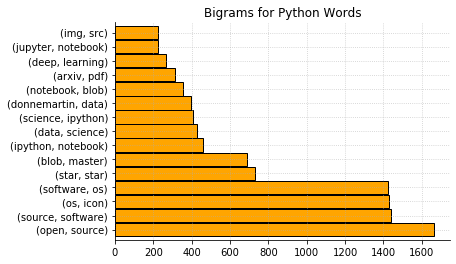

In [22]:
pd.Series(nltk.bigrams(python_words)).value_counts().head(15).plot.barh(width=.95, color='orange').set_title('Bigrams for Python Words')

Text(0.5, 1.0, 'Bigrams for JavaScript Words')

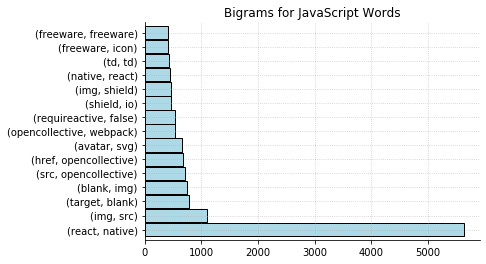

In [23]:
pd.Series(nltk.bigrams(javascript_words)).value_counts().head(15).plot.barh(width=.95, color='lightblue').set_title('Bigrams for JavaScript Words')

Text(0.5, 1.0, 'Bigrams for PHP Words')

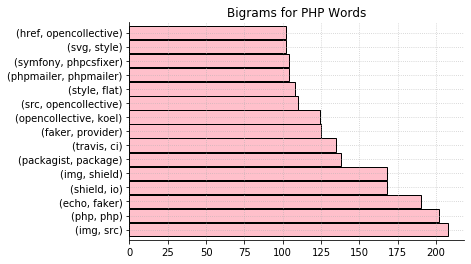

In [24]:
pd.Series(nltk.bigrams(php_words)).value_counts().head(15).plot.barh(width=.95, color='pink').set_title('Bigrams for PHP Words')

Text(0.5, 1.0, 'Bigrams for Shell Words')

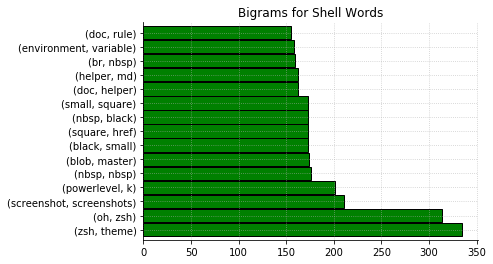

In [25]:
pd.Series(nltk.bigrams(shell_words)).value_counts().head(15).plot.barh(width=.95, color='green').set_title('Bigrams for Shell Words')

- Trigrams and visualizations of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Trigrams for All Words')

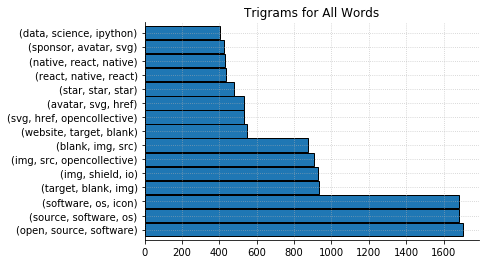

In [26]:
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for All Words')

Text(0.5, 1.0, 'Trigrams for Python Words')

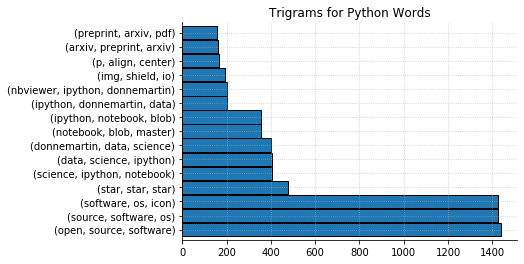

In [27]:
pd.Series(nltk.ngrams(python_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Python Words')

Text(0.5, 1.0, 'Trigrams for JavaScript Words')

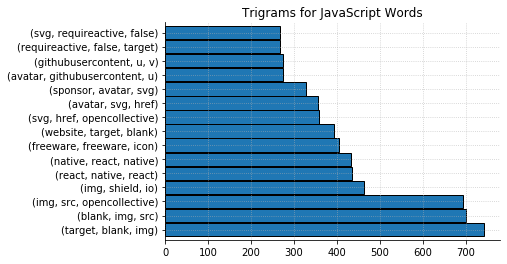

In [28]:
pd.Series(nltk.ngrams(javascript_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for JavaScript Words')

Text(0.5, 1.0, 'Trigrams for PHP Words')

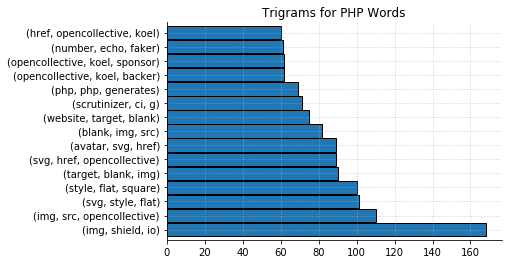

In [29]:
pd.Series(nltk.ngrams(php_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for PHP Words')

Text(0.5, 1.0, 'Trigrams for Shell Words')

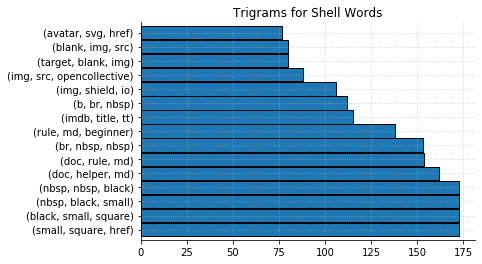

In [30]:
pd.Series(nltk.ngrams(shell_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Shell Words')

### Document Length

In [31]:
lemmas_df["length"] = lemmas_df.lemmatized.apply(len)
lemmas_df.drop(index = lemmas_df[lemmas_df.length > 140000].index, inplace = True)

Text(0.5, 1.0, 'Document Length')

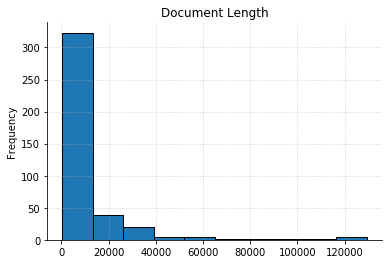

In [32]:
lemmas_df.length.plot.hist().set_title('Document Length')

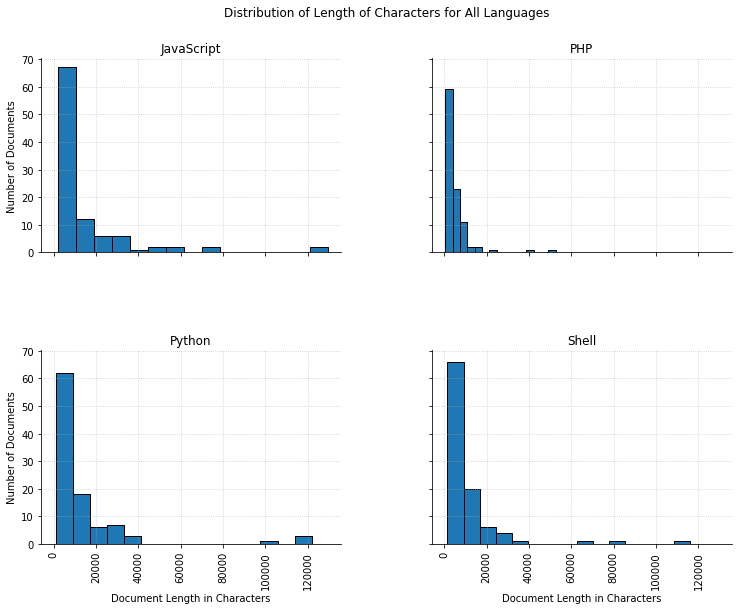

In [33]:
ar = lemmas_df.hist("length", by="language", sharex=True, sharey = True, layout=(2, 2), bins=15, figsize=(12, 9))
plt.suptitle('Distribution of Length of Characters for All Languages')

for ax in ar.flatten():
    ax.set_xlabel('Document Length in Characters')
    ax.set_ylabel('Number of Documents')
    ax.set

Text(0.5, 0, 'Length in Characters')

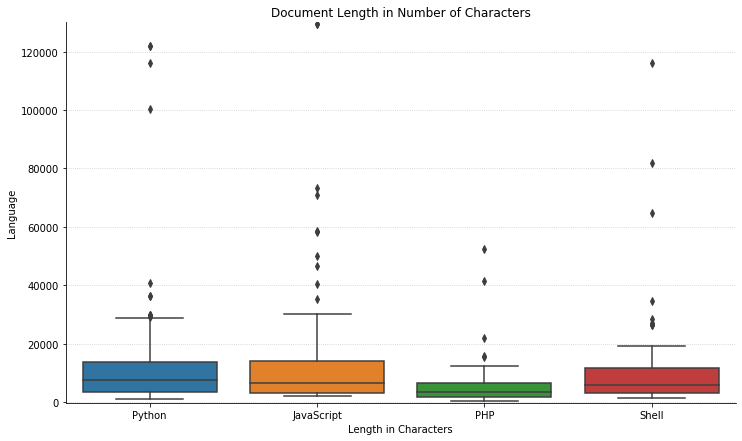

In [34]:
fig = plt.figure(figsize=(12, 7))

ax = sns.boxplot(data=lemmas_df, y="length", x="language")
ax.set_title('Document Length in Number of Characters')
ax.set_ylabel('Language')
ax.margins(.005) 
ax.set_xlabel('Length in Characters')

### Number of Words

In [35]:
lemmas_df["n_words"] = lemmas_df.lemmatized.str.count(r"\w+")

In [36]:
lemmas_df.groupby("language").n_words.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
JavaScript,100.0,2121.71,3158.797292,333.0,485.00,942.0,1997.00,18256.0
PHP,100.0,728.82,998.429933,60.0,230.25,478.0,914.50,7202.0
Python,100.0,2058.59,3216.770719,176.0,540.00,1073.0,2279.75,17444.0
Shell,100.0,1569.35,2319.130686,235.0,486.00,889.5,1697.50,16737.0


Text(0.5, 1.0, 'Document Length in Number of Words')

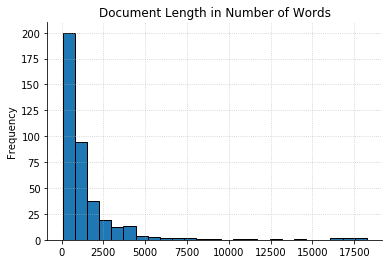

In [37]:
lemmas_df.n_words.plot.hist(bins = 25).set_title('Document Length in Number of Words')

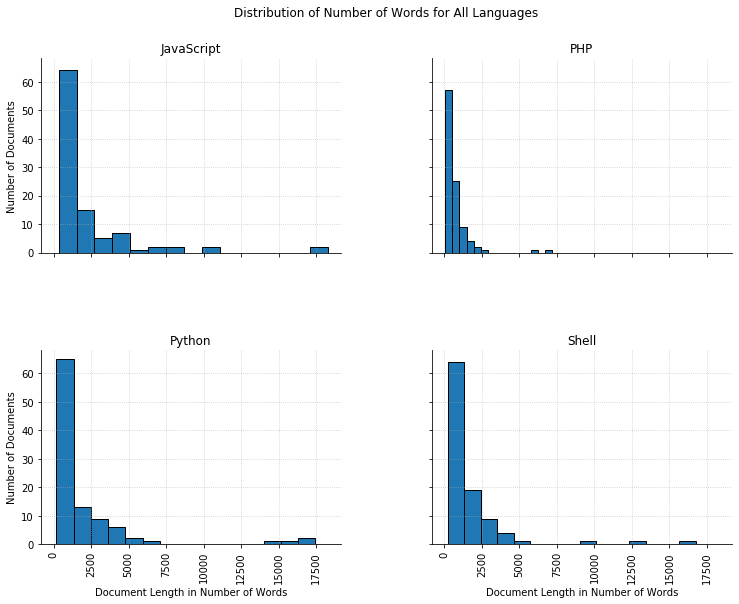

In [38]:
ar = lemmas_df.hist("n_words", by="language", sharex=True, sharey = True, layout=(2, 2), bins=15, figsize=(12, 9))
plt.suptitle("Distribution of Number of Words for All Languages")

for ax in ar.flatten():
    ax.set_xlabel('Document Length in Number of Words')
    ax.set_ylabel('Number of Documents')

### Word Cloud

- WordCloud with all words

(-0.5, 1499.5, 999.5, -0.5)

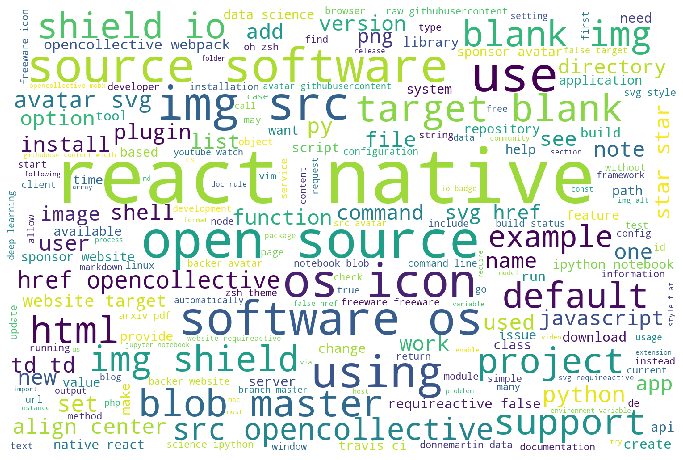

In [39]:
corpus = ' '.join(all_words)

plt.figure(figsize=(12,12))
img = WordCloud(background_color="white", height=1000, width=1500, random_state=123).generate(corpus)
plt.imshow(img)
plt.axis("off")

- WordCloud with all words by languages

In [40]:
python_corpus = ' '.join(python_words)
javascript_corpus = ' '.join(javascript_words)
php_corpus = ' '.join(php_words)
shell_corpus = ' '.join(shell_words)

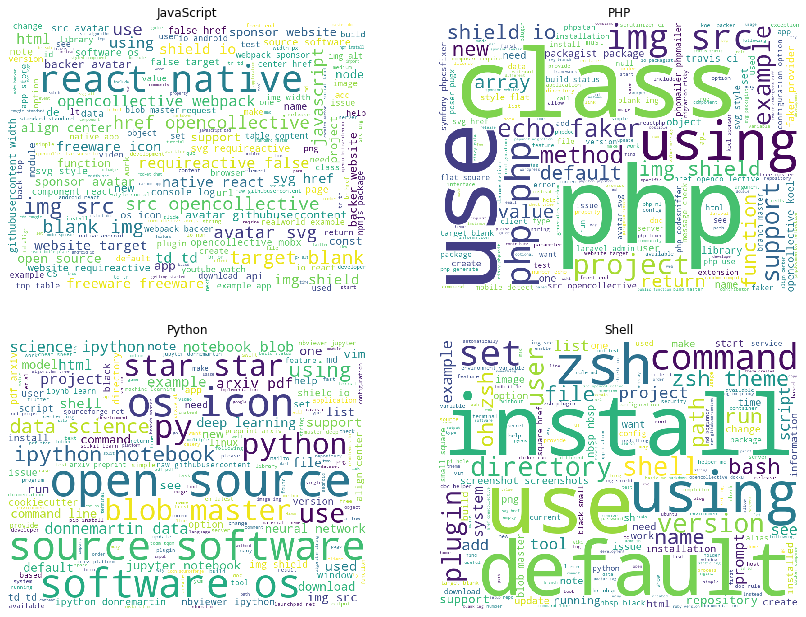

In [41]:
python_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(python_words)
)
javascript_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(javascript_words)
)
php_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(php_words)
)
shell_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(shell_words)
)

plt.figure(figsize=(10, 8))
axs = [
    plt.axes([0, 0, 0.5, 0.5]),
    plt.axes([0, 0.55, 0.5, .5]),
    plt.axes([0.6, 0.55, 0.5, 0.5]),
    plt.axes([0.6, 0, 0.5, 0.5]),
]

axs[0].imshow(python_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(php_cloud)
axs[3].imshow(shell_cloud)

axs[0].set_title("Python")
axs[1].set_title("JavaScript")
axs[2].set_title("PHP")
axs[3].set_title("Shell")

for ax in axs:
    ax.axis("off")    

### Word Cloud with Bigrams

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with All Words')

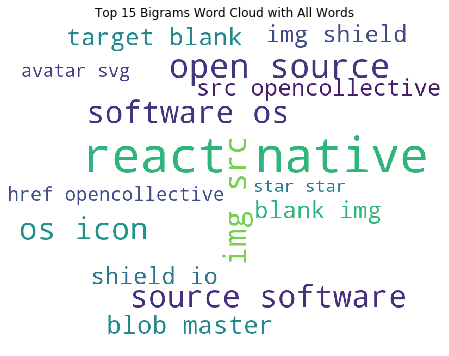

In [42]:
all_bigrams = pd.Series(nltk.bigrams(all_words)).value_counts().head(15)

all_data = {p1 + " " + p2: v for (p1, p2), v in all_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(all_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with All Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with Python Words')

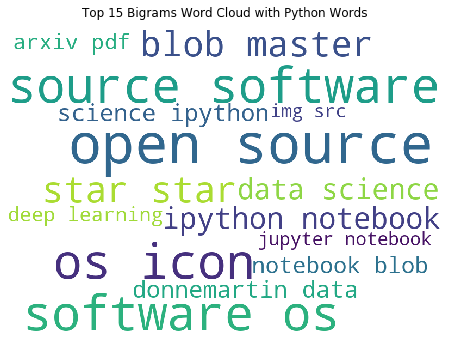

In [43]:
python_bigrams = pd.Series(nltk.bigrams(python_words)).value_counts().head(15)

python_data = {p1 + " " + p2: v for (p1, p2), v in python_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(python_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with Python Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with JavaScript Words')

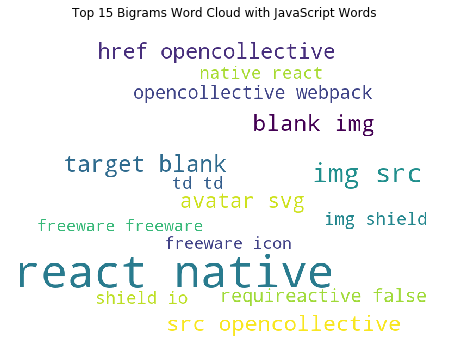

In [44]:
javascript_bigrams = pd.Series(nltk.bigrams(javascript_words)).value_counts().head(15)

javascript_data = {p1 + " " + p2: v for (p1, p2), v in javascript_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(javascript_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with JavaScript Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with PHP Words')

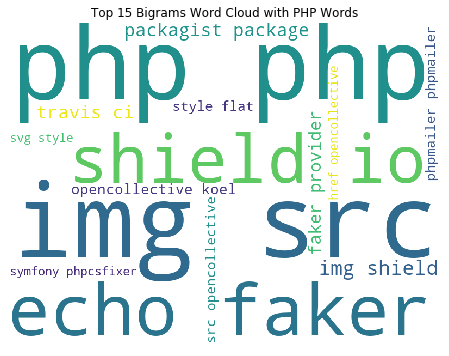

In [45]:
php_bigrams = pd.Series(nltk.bigrams(php_words)).value_counts().head(15)

php_data = {p1 + " " + p2: v for (p1, p2), v in php_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(php_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with PHP Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with Shell Words')

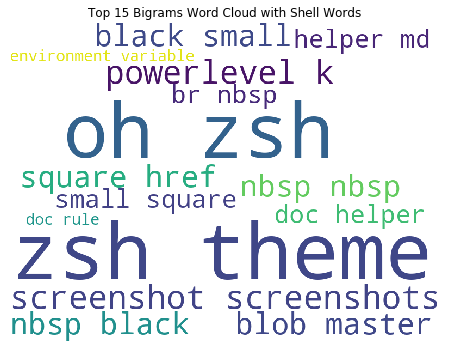

In [46]:
shell_bigrams = pd.Series(nltk.bigrams(shell_words)).value_counts().head(15)

shell_data = {p1 + " " + p2: v for (p1, p2), v in shell_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(shell_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with Shell Words')

### Word Cloud with Trigrams

Text(0.5, 1.0, 'Top 15 Trigrams with All Words')

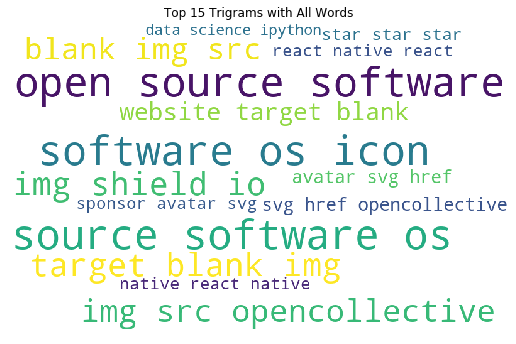

In [47]:
all_trigrams = pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in all_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with All Words')

Text(0.5, 1.0, 'Top 15 Trigrams with Python Words')

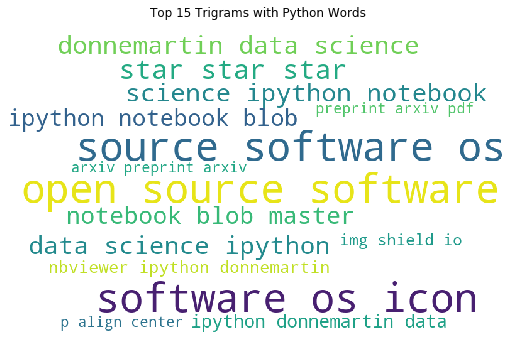

In [48]:
python_trigrams = pd.Series(nltk.ngrams(python_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in python_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with Python Words')

Text(0.5, 1.0, 'Top 15 Trigrams with JavaScript Words')

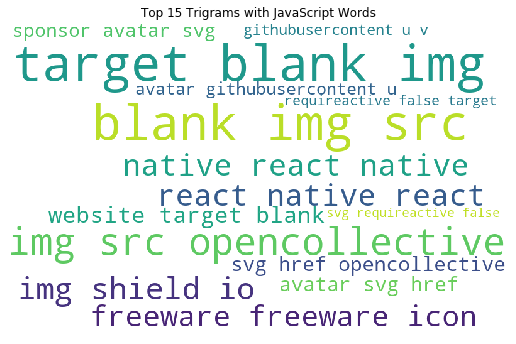

In [49]:
javascript_trigrams = pd.Series(nltk.ngrams(javascript_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in javascript_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with JavaScript Words')

Text(0.5, 1.0, 'Top 15 Trigrams with PHP Words')

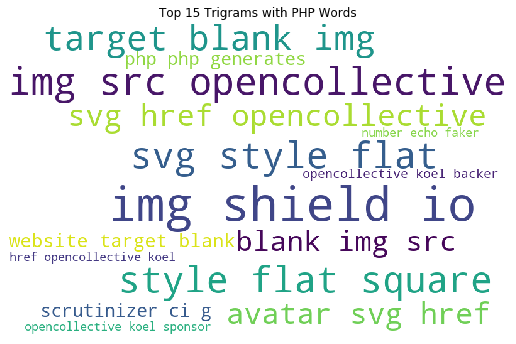

In [50]:
php_trigrams = pd.Series(nltk.ngrams(php_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in php_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with PHP Words')

Text(0.5, 1.0, 'Top 15 Trigrams with Shell Words')

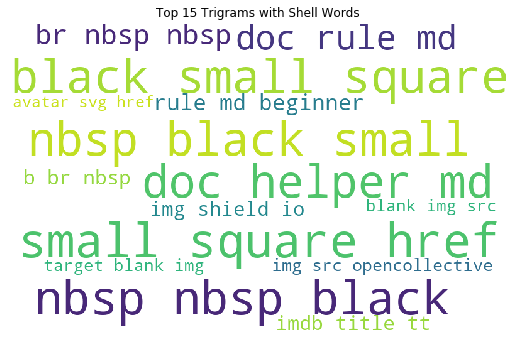

In [51]:
shell_trigrams = pd.Series(nltk.ngrams(shell_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in shell_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with Shell Words')

Modeling

In [52]:
import model
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

First we get a dataframe that includes word count and unique words columns. This was necessary to compute Term Frequency - Inverse Document Frequency for our models.

In [62]:
df = prepare.prep(model=True)
df.head()

,language,title,original,cleaned,stemmed,lemmatized,length,word_count,unique_words
0,Python,donnemartin/system-design-primer,*[English](README.md) ∙ [日本語](README-ja.md) ∙ ...,english readme md readme ja md readme zh hans ...,english readm md readm ja md readm zh han md r...,english readme md readme ja md readme zh han m...,29769,4321,1129
1,Python,nvbn/thefuck,# The Fuck [![Version][version-badge]][version...,fuck version version badge version link build ...,fuck version version badg version link build s...,fuck version version badge version link build ...,17369,2641,699
10,Python,deepfakes/faceswap,"# deepfakes_faceswap\n<p align=""center"">\n <a...",deepfakes faceswap p align center href faceswa...,deepfak faceswap p align center href faceswap ...,deepfakes faceswap p align center href faceswa...,8256,1182,559
100,Python,equinusocio/material-theme,"<p align=""center"">\n <h3>\n This project...",p align center h project longer active develop...,p align center h project longer activ develop ...,p align center h project longer active develop...,8007,1184,401
101,Python,powerline/powerline,Powerline\n=========\n\n:Author: Kim Silkebækk...,powerline author kim silkebkken kim silkebaekk...,powerlin author kim silkebkken kim silkebaekke...,powerline author kim silkebkken kim silkebaekk...,2940,397,190


The below function, prevent_overfitting, creates the model specified in the first argument using the dataframe provided in the second. It then splits the data into x_train, x_test, y_train, and y_test. We chose to use a 20% portion for testing. The x-values are the Term Frequency - Inverse Document Frequency of each word in our corpus, by document. The y-value is what programming language of each document.

It initializes the model with min_samples_leaf = 1, and iterates upward until the difference between the train accuracy and test accuracy is less than .06. Finally, it prints the ultimate min_samples_leaf value, accuracy in train data set, and accuracy in test data set.

In [59]:
dt = model.prevent_overfitting(DecisionTreeClassifier, df)

leaf = 18
train acc = 0.8224720818564399
test acc = 0.8114784389417192


We did the same with a Random Forest model, but it performed significantly worse.

In [67]:
rf = model.prevent_overfitting(RandomForestClassifier, df)

leaf = 27
train acc = 0.5594455527057409
test acc = 0.514551087604677


When running our evaluation metrics, they often change due to some randomness in the modeling. The below scores reflect the highest we've seen, which is the model we stored to predict future READMEs.

In [61]:
dt = model.get_model()

In [66]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df.lemmatized)
y = df.language

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.2, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

train['predicted'] = dt.predict(x_train)
test['predicted'] = dt.predict(x_test)
train_acc = score(train.actual, train.predicted)[2].mean()
test_acc = score(test.actual, test.predicted)[2].mean()

print(f'train acc = {train_acc}')
print(f'test acc = {test_acc}')

train acc = 0.9155384388092253
test acc = 0.9254324010421571
